In [1]:
import toolz as fp
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import numpy.random as random
import sys
from importlib import reload
import shap

def reload_all(target):
    list(fp.map(lambda y: reload(sys.modules[y]) if sys.modules[y] else None, list(fp.remove(lambda x: target not in x, sys.modules.keys()))))

In [2]:
reload_all('fklearn')

In [3]:
from fklearn.training.transformation import capper, floorer, prediction_ranger
from fklearn.training.pipeline import build_pipeline

/home/victor/anaconda3/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [4]:
from fklearn.validation.evaluators import mean_prediction_evaluator, r2_evaluator, mse_evaluator, combined_evaluators
from fklearn.validation.validator import validator
from fklearn.validation.splitters import k_fold_splitter, out_of_time_and_space_splitter
from fklearn.metrics.pd_extractors import evaluator_extractor as pd_evaluator_extractor, extract as pd_extract, \
                                        reverse_learning_curve_evaluator_extractor, evaluator_extractor, extract ## different from pd_extractor

# Training and Evaluating Simple Model

### Generate data

In [5]:
random.seed(131)
dates = pd.DataFrame( {"score_date": pd.date_range("2016-01-01", "2016-12-31")} )
ids = pd.DataFrame( {"id": np.arange(0, 100)} )

# make keys for cross join
dates["key"] = 1
ids["key"] = 1

data = pd.merge(ids, dates).drop("key", axis=1)

data["x1"] = 23*random.randn(data.shape[0]) + 500
data["x2"] = 59*random.randn(data.shape[0]) + 235
# Noise Feature
data["x3"] = 73*random.randn(data.shape[0]) + 793
data["y"] = 0.37 * data["x1"] +\
            0.97*data["x2"] + 0.32*data["x2"]**2 -\
            5 * data["id"] * 0.2 +\
            np.cos(pd.to_datetime(data["score_date"]).astype(int) * 200) * 20
            
# inject NaNs
nan_idx = np.random.randint(0, data.shape[0], size=100)
data.loc[nan_idx, "x1"] = np.nan

nan_idx = np.random.randint(0, data.shape[0], size=100)
data.loc[nan_idx, "x2"] = np.nan

In [6]:
data.head()

,id,score_date,x1,x2,x3,y
0,0,2016-01-01,510.355134,283.921165,790.444246,26239.886697
1,0,2016-01-02,503.469826,363.195827,653.370214,42767.340728
2,0,2016-01-03,536.412361,284.165730,746.477652,26306.062249
3,0,2016-01-04,471.144774,213.844006,830.487358,15011.179520
4,0,2016-01-05,482.795605,236.722618,841.487464,18354.817603


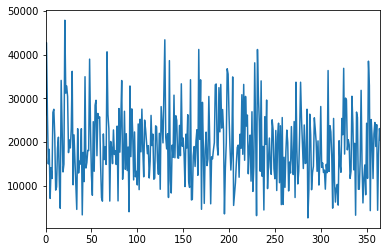

In [7]:
data["y"][data["id"] == 0].plot()
plt.show()

### Train Test Split 

In [8]:
from fklearn.preprocessing.splitting import space_time_split_dataset
train_start = "2016-01-01"
train_end = "2016-06-30"
holdout_end = "2016-12-31"

split_fn = space_time_split_dataset(train_start_date=train_start,
                                     train_end_date=train_end,
                                     holdout_end_date=holdout_end,
                                     split_seed=42, space_holdout_percentage=.05,
                                     space_column="id", time_column="score_date")

In [9]:
train_set, intime_outspace_hdout, outime_inspace_hdout, outime_outspace_hdout = split_fn(data)

train_set.shape, intime_outspace_hdout.shape, outime_inspace_hdout.shape, outime_outspace_hdout.shape

((17195, 6), (905, 6), (18400, 6), (920, 6))

### Define learner function

In [10]:
FEATURES = ["x1", "x2", "x3"]
TARGET = ["y"]

In [11]:
from fklearn.training.imputation import imputer
my_imputer = imputer(columns_to_impute=FEATURES, impute_strategy="median")

In [12]:
from fklearn.training.transformation import standard_scaler
my_scaler = standard_scaler(columns_to_scale=FEATURES)

In [13]:
from fklearn.training.regression import catboost_regressor_learner
my_model = catboost_regressor_learner(features=['x1', 'x2', 'x3'], target='y', prediction_column='prediction', extra_params={'random_seed': 139, 'thread_count': 8})

In [14]:
reload_all('fklearn')
from fklearn.training.transformation import ecdfer
my_ecdefer = ecdfer(prediction_column="prediction", ecdf_column="prediction_ecdf")

In [15]:
my_learner = build_pipeline(my_imputer, my_scaler, my_model, my_ecdefer)

### Train

In [16]:
(prediction_function, _, logs) = my_learner(train_set)

### Evaluate

In [17]:
my_evaluator = combined_evaluators(evaluators=[
    mean_prediction_evaluator(prediction_column='prediction'),
    r2_evaluator(prediction_column='prediction', target_column='y'),
    mse_evaluator(prediction_column='prediction', target_column='y'),
])

In [18]:
test_predictions = prediction_function(outime_outspace_hdout)

In [19]:
# first argument (training_data) is optional. Only some kinds of evaluators need it. (e.g. learning curve)
# I should probably get rid of it and come up with a better way to pass training information for evaluation
my_evaluator(test_predictions)

{'mean_evaluator__prediction': 19555.932935317716,
 'r2_evaluator__y': 0.9985154268396046,
 'mse_evaluator__y': 114489.46983097984}